In [ ]:
import os
import numpy as np
import pandas as pd
!pip install wordcloud
!pip install nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import word_tokenize
from nltk.corpus import state_union
from nltk.tag import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import matplotlib.pyplot as plt
import collections, re
import string
import pylab as plt

#1. Importing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#2. Exploring and preparing the data

**Processing data for analysis**


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Eluvio/Eluvio_DS_Challenge.csv')
data.head()

,time_created,date_created,up_votes,down_votes,title,over_18,author,category
0,1201232046,2008-01-25,3,0,Scores killed in Pakistan clashes,False,polar,worldnews
1,1201232075,2008-01-25,2,0,Japan resumes refuelling mission,False,polar,worldnews
2,1201232523,2008-01-25,3,0,US presses Egypt on Gaza border,False,polar,worldnews
3,1201233290,2008-01-25,1,0,Jump-start economy: Give health care to all,False,fadi420,worldnews
4,1201274720,2008-01-25,4,0,Council of Europe bashes EU&UN terror blacklist,False,mhermans,worldnews


**Clean Data**

In [ ]:
# We do not need category and time_created columns
data = data.drop(['category','time_created'],axis=1)

# Drop duplicated rows
data.drop_duplicates(inplace=True)

# date_created column's type should be datatime
data["date_created"] = pd.to_datetime(data["date_created"])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509190 entries, 0 to 509235
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_created  509190 non-null  datetime64[ns]
 1   up_votes      509190 non-null  int64         
 2   down_votes    509190 non-null  int64         
 3   title         509190 non-null  object        
 4   over_18       509190 non-null  bool          
 5   author        509190 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(2)
memory usage: 23.8+ MB


In [ ]:
false = data['over_18'][data.over_18 == 0]
true = data['over_18'][data.over_18 == 1]

print('number of stories were deemed to be under 18 is {}'.format(len(false)))
print('number of stories were deemed to be over 18 is:  {}'.format(len(true)))
print('total stories is:                                {}'.format(data.shape[0]))

number of stories were deemed to be under 18 is 508910
number of stories were deemed to be over 18 is:  320
total stories is:                                509230


There are total 320 posts over 18 years old meanwhile 508916 posts under 18 years old

In [ ]:
# get unique over_18 counts
data.groupby('over_18').describe()

up_votes                                      ... Label_enc                    
            count        mean          std  min   25%  ...       min  25%  50%  75%  max
over_18                                                ...                              
False    508870.0  112.077759   541.193355  0.0  1.00  ...       0.0  1.0  1.0  1.0  2.0
True        320.0  380.375000  1062.401351  0.0  1.75  ...       0.0  0.0  1.0  2.0  2.0

[2 rows x 40 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


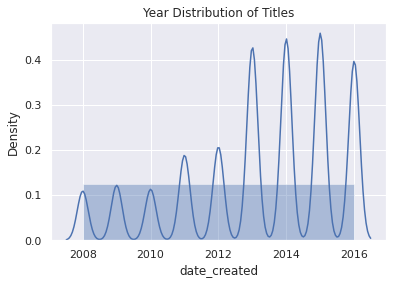

In [ ]:
import seaborn as sns
sns.set()
# Plot the histogram of Year
sns.distplot(data["date_created"].dt.year, bins=1)
plt.title("Year Distribution of Titles")
plt.show()


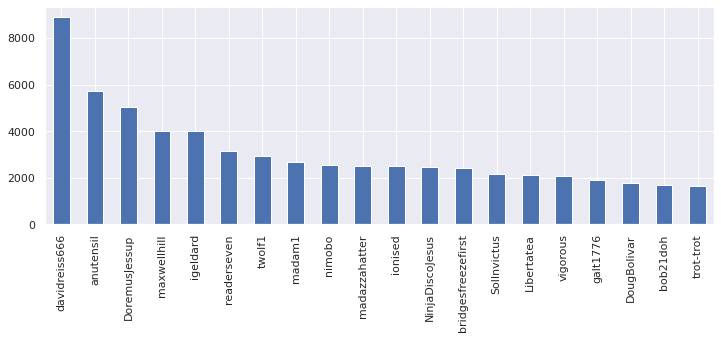

In [ ]:
#Who is the top poster
user= data.author.value_counts()[:20]
user.plot.bar(figsize= (12, 4))

davidreiss666 is the top poster

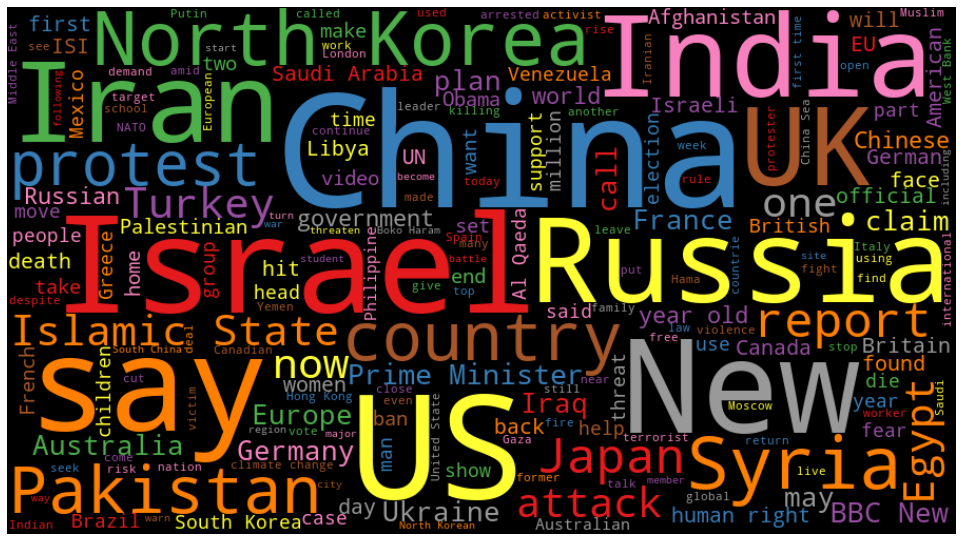

In [ ]:
title = []
for msg in data['title']:
  if (type(msg) == str):
    title.append(msg)
text = ' '.join(title)
wordcloud = WordCloud(width=900,
                      height=500,
                      max_font_size=150,
                      relative_scaling=0.5,
                      colormap='Set1',
                      normalize_plurals=True).generate(text)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Bag of Words**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['title'], 25)

china 26395
says 25431
new 23382
syria 19021
russia 18763
world 18090
police 16652
government 16304
israel 16047
iran 15813
president 15269
killed 14328
people 13991
state 13489
attack 12925
war 12819
russian 12375
military 11828
uk 11784
north 11588
south 11550
korea 11536
year 11519
news 11429
minister 11014


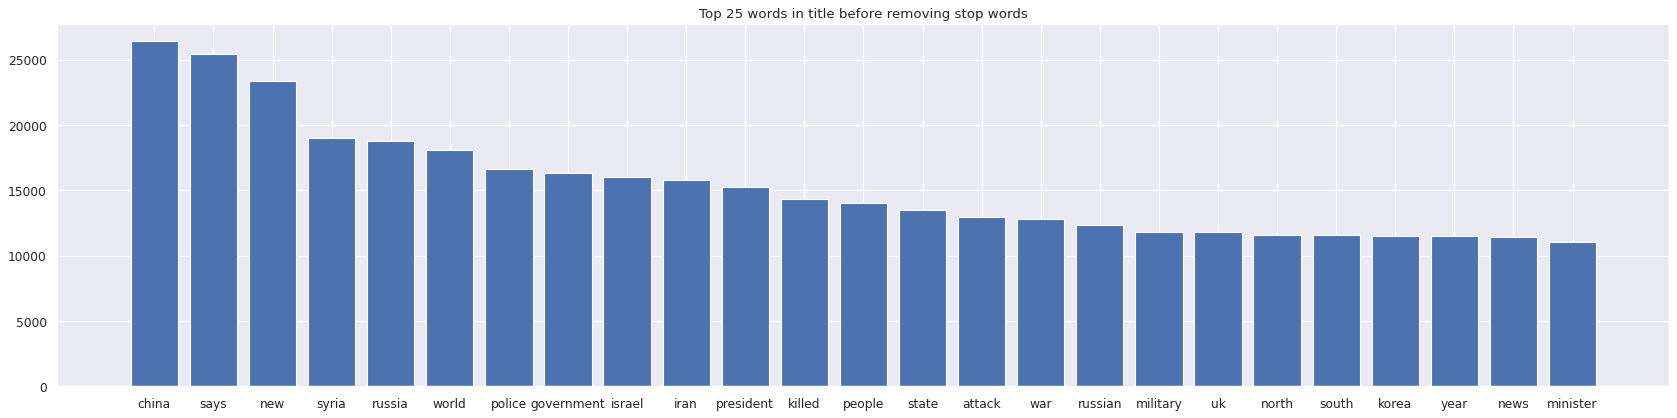

In [ ]:
for word, freq in common_words:
    print(word, freq)
figure(figsize=(26, 6), dpi=80)
plt.bar([v[0] for v in common_words], [v[1] for v in common_words])
plt.title('Top 25 words in title before removing stop words')

plt.show()

china 26395
says 25431
new 23382
syria 19021
russia 18763
world 18090
police 16652
government 16304
israel 16047
iran 15813
president 15269
killed 14328
people 13991
state 13489
attack 12925
war 12819
russian 12375
military 11828
uk 11784
north 11588
south 11550
korea 11536
year 11519
news 11429
minister 11014


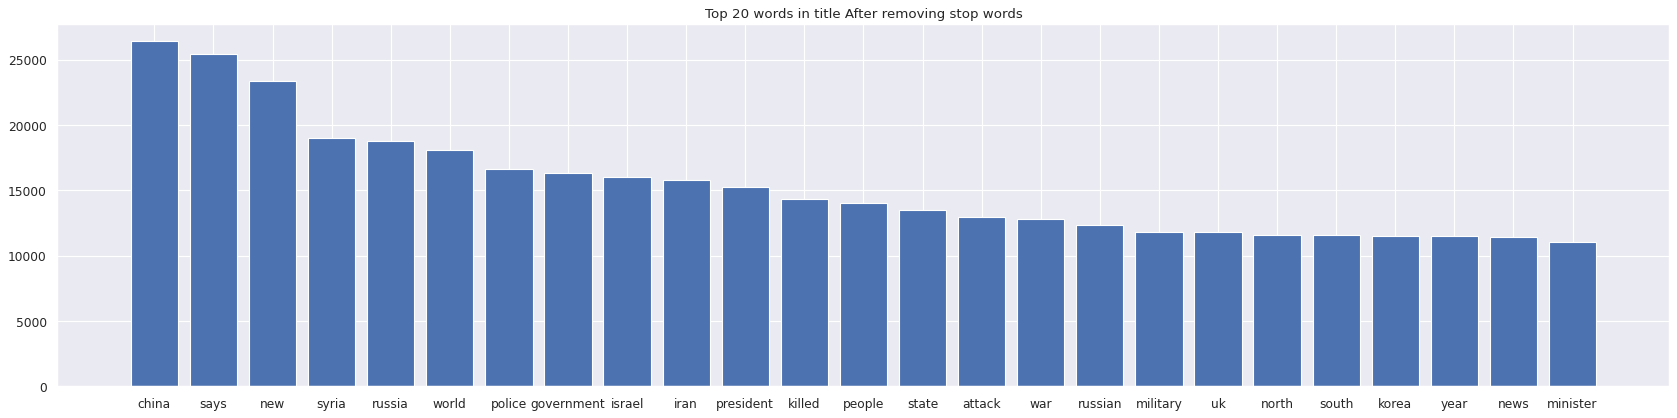

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['title'], 25)


for word, freq in common_words:
    print(word, freq)
figure(figsize=(26, 6), dpi=80)
plt.bar([v[0] for v in common_words], [v[1] for v in common_words])
plt.title('Top 20 words in title After removing stop words')
plt.show()


In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_bigram = get_top_n_bigram(data['title'], 25)

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words_trigram = get_top_n_trigram(data['title'], 25)

north korea 7111
islamic state 5309
prime minister 4797
bbc news 4173
year old 3780
human rights 3547
saudi arabia 3493
south korea 2701
al qaeda 2638
climate change 2284
united states 2220
hong kong 2062
middle east 1828
china sea 1745
west bank 1735
boko haram 1678
south china 1628
south africa 1610
north korean 1533
new zealand 1521


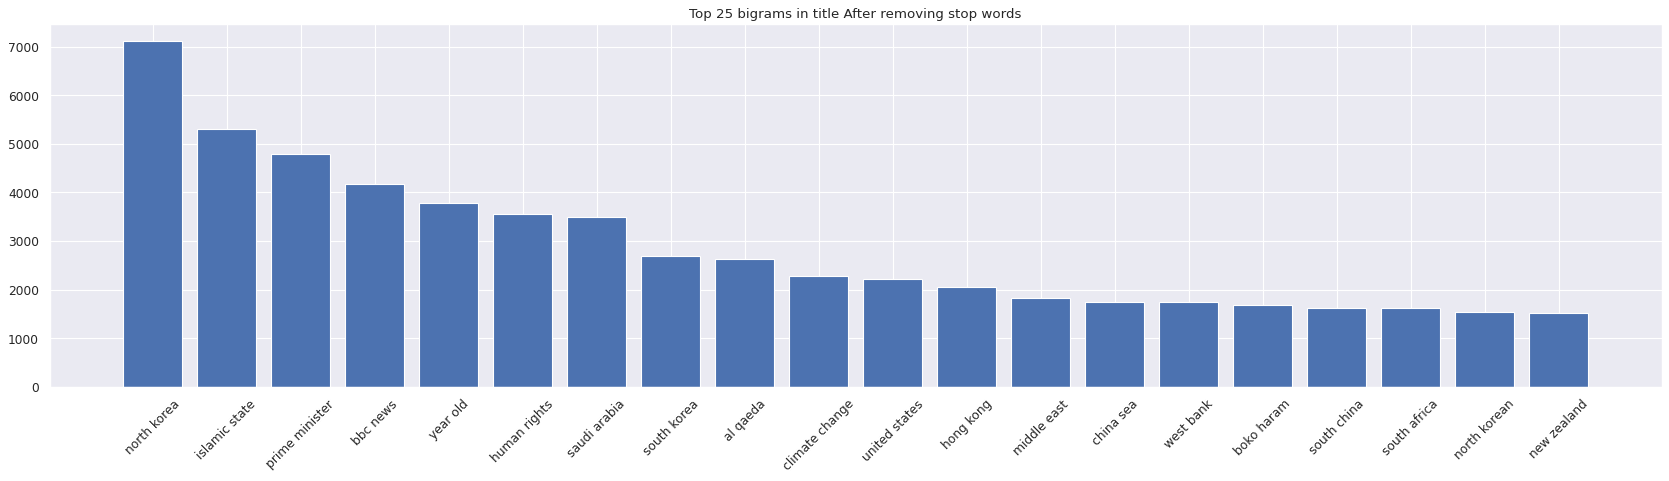

south china sea 1556
bashar al assad 667
central african republic 570
al jazeera english 477
human rights watch 447
president bashar al 434
osama bin laden 411
year old girl 403
president vladimir putin 383
nobel peace prize 363
new york times 350
islamic state militants 337
world war ii 328
president barack obama 325
international criminal court 316
great barrier reef 310
ban ki moon 302
islamic state group 291
nuclear power plant 288
death toll rises 286
chancellor angela merkel 282
year old boy 280
kim jong il 262
iran nuclear deal 251
papua new guinea 248


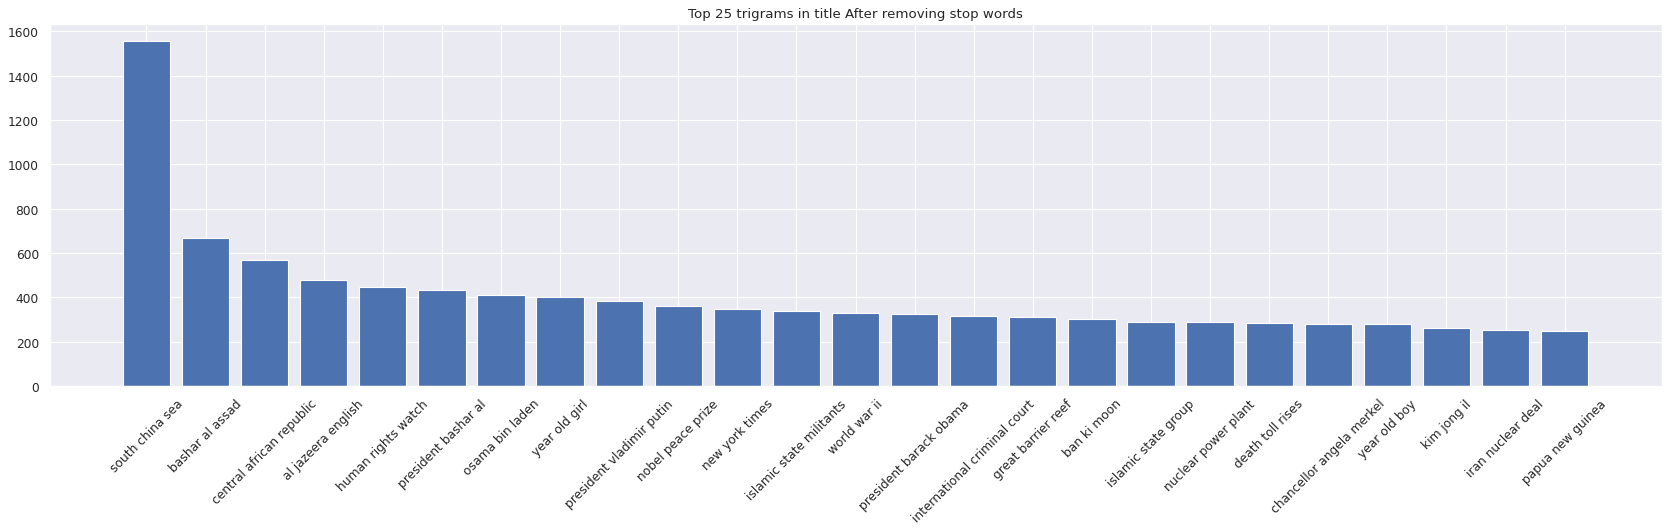

In [ ]:
for word, freq in common_words_bigram:
    print(word, freq)

figure(figsize=(26, 6), dpi=80)
plt.bar([v[0] for v in common_words_bigram], [v[1] for v in common_words_bigram])
plt.title('Top 25 bigrams in title After removing stop words')
plt.xticks(rotation=45)
plt.show()
for word, freq in common_words_trigram:
    print(word, freq)

figure(figsize=(26, 6), dpi=80)
plt.bar([v[0] for v in common_words_trigram], [v[1] for v in common_words_trigram])
plt.title('Top 25 trigrams in title After removing stop words')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#Post with the most upvotes
data['up_votes'].sort_values(ascending=False).value_counts().head()

0    93523
1    46610
2    44194
3    36111
4    29915
Name: up_votes, dtype: int64

In [ ]:
#check for most upvoted headline
[title for title in data.sort_values('up_votes', ascending=False)['title'][:10]]

['A biotech startup has managed to 3-D print fake rhino horns that carry the same genetic fingerprint as the actual horn. The company plans to flood Chinese rhino horn market at one-eighth of the price of the original, undercutting the price poachers can get and forcing them out eventually.',
 'Twitter has forced 30 websites that archive politician s deleted tweets to shut down, removing an effective tool to keep politicians honest',
 '2.6 terabyte leak of Panamanian shell company data reveals  how a global industry led by major banks, legal firms, and asset management companies secretly manages the estates of politicians, Fifa officials, fraudsters and drug smugglers, celebrities and professional athletes. ',
 'The police officer who leaked the footage of the surfers paradise police brutality, where the victims blood was washed away by officers, has been criminally charged for bringing it to the publics view. Officers who did the bashing get nothing.',
 'Paris shooting survivor suing 

In [ ]:
#Post with the most downvotes
data['down_votes'].sort_values(ascending=False).value_counts().head()

0    509190
Name: down_votes, dtype: int64

We can see that no post with downvotes

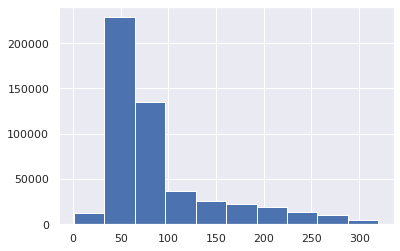

In [ ]:
#Length of Sentences
data.title.str.len().hist()

*Print the dates*

In [ ]:
# Print the minimum datetime
print("Since:",data["date_created"].min())

# Print the maximum datetime
print("Until",data["date_created"].max())

Since: 2008-01-25 00:00:00
Until 2016-11-22 00:00:00


**Sentime Analysis**

Get polarity and subjectivity scores of the text with TextBlob



In [ ]:
from textblob import TextBlob

# Add polarities and subkectivities into the DataFrame by using TextBlob
data["Polarity"] = data["title"].apply(lambda word: TextBlob(word).sentiment.polarity)
data["Subjectivity"] = data["title"].apply(lambda word: TextBlob(word).sentiment.subjectivity)

# Display the Polarity and Subjectivity columns
display(data[["Polarity","Subjectivity"]].head(10))

,Polarity,Subjectivity
0,-0.20,0.0
1,0.00,0.0
2,0.00,0.0
3,0.00,0.0
4,0.00,0.0
5,-0.45,0.6
6,0.00,0.0
7,0.00,0.0
8,0.00,0.0
9,0.00,0.0


Classify the polarities. if:

* polarity > 0 --> positive
* polarity = 0 --> neutral
* polarity < 0 --> negative





In [ ]:
# Define a function to classify polarities
def analyse_polarity(polarity):
    if polarity > 0:
        return "Positive"
    if polarity == 0:
        return "Neutral"
    if polarity < 0:
        return "Negative"

# Apply the funtion on Polarity column and add the results into a new column
data["Label"] = data["Polarity"].apply(analyse_polarity)

# Display the Polarity and Subjectivity Analysis
display(data[["Label"]].head(10))

,Label
0,Negative
1,Neutral
2,Neutral
3,Neutral
4,Neutral
5,Negative
6,Neutral
7,Neutral
8,Neutral
9,Neutral


We can also count them up like the following.



In [ ]:
# Print the value counts of the Label column
print(data["Label"].value_counts())

Neutral     272273
Positive    126369
Negative    110548
Name: Label, dtype: int64


We tagged the title as positive, neutral, and negative so far.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


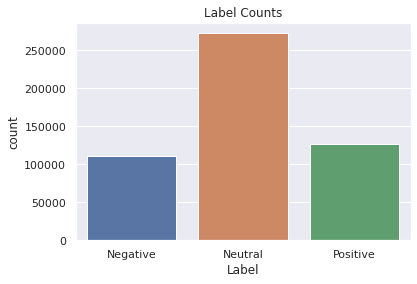

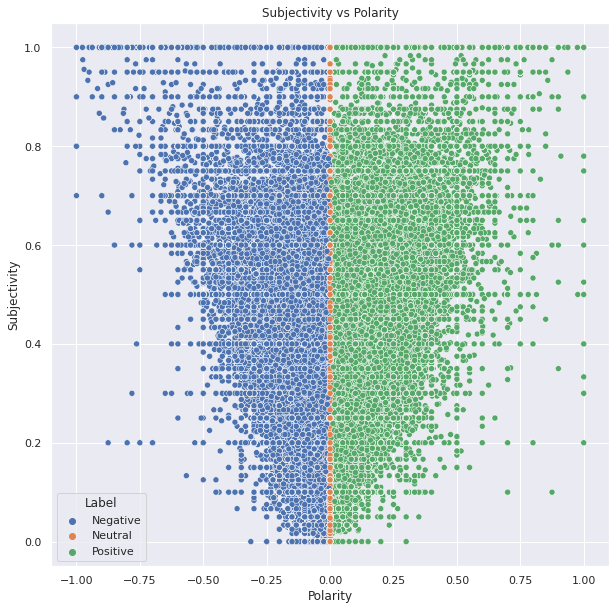

In [ ]:
# Change the datatype as "category"
data["Label"] = data["Label"].astype("category")

# Visualize the Label counts
sns.countplot(data["Label"])
plt.title("Label Counts")
plt.show()

# Visualize the Polarity scores
plt.figure(figsize = (10, 10)) 
sns.scatterplot(x="Polarity", y="Subjectivity", hue="Label", data=data)
plt.title("Subjectivity vs Polarity")
plt.show()

##Check the time which can show something about polarity?


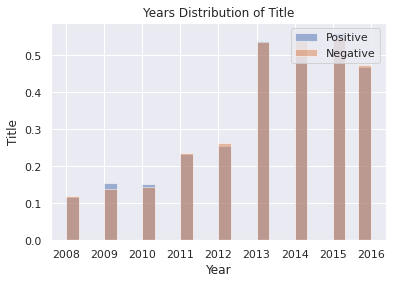

In [ ]:
positive = data.loc[data.Label=="Positive"]["date_created"].dt.year
negative = data.loc[data.Label=="Negative"]["date_created"].dt.year

plt.hist(positive, alpha=0.5, bins=24, label="Positive", density=True)
plt.hist(negative, alpha=0.5, bins=24, label="Negative", density=True)
plt.xlabel("Year")
plt.ylabel("Title")
plt.title("Years Distribution of Title")
plt.legend(loc='upper right')
plt.show()

#3. Train Test Split

In [ ]:
# Encode the labels
le = LabelEncoder()
data["Label_enc"] = le.fit_transform(data["Label"])

# Display the encoded labels
display(data[["Label_enc"]].head())

# Select the features and the target
X = data['title']
y = data["Label_enc"]

,Label_enc
0,0
1,1
2,1
3,1
4,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34, stratify=y)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize a Tf-idf Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)


In [ ]:
# Create the tf-idf vectorizer
model_vectorizer = TfidfVectorizer()

# First fit the vectorizer with our training set
tfidf_train = vectorizer.fit_transform(X_train)

# Now we can fit our test data with the same vectorizer
tfidf_test = vectorizer.transform(X_test)

# Initialize the Bernoulli Naive Bayes classifier
nb = BernoulliNB()

# Fit the model
nb.fit(tfidf_train, y_train)

# Print the accuracy score
best_accuracy = cross_val_score(nb, tfidf_test, y_test, cv=10, scoring='accuracy').max()
print("Accuracy:",best_accuracy)

Accuracy: 0.7925955023077679


#4. Evaluate the model

##Using Multinomial Naive Bayes Classifier

In [ ]:
# Predict the labels
y_pred = nb.predict(tfidf_test)

# Print the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix\n")
print(cm)

# Print the Classification Report
cr = classification_report(y_test, y_pred)
print("\n\nClassification Report\n")
print(cr)

Confusion Matrix

[[15505  3293  3311]
 [ 2323 47723  4409]
 [ 2126  4862 18286]]


Classification Report

              precision    recall  f1-score   support

           0       0.78      0.70      0.74     22109
           1       0.85      0.88      0.87     54455
           2       0.70      0.72      0.71     25274

    accuracy                           0.80    101838
   macro avg       0.78      0.77      0.77    101838
weighted avg       0.80      0.80      0.80    101838

